## Лабораторная работа № 3

Импортируем необходимые библиотеки.

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Flatten
from keras.layers import SimpleRNN, Reshape
from keras.layers import GRU, Embedding
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
import os
import string

Using TensorFlow backend.


Скачаем текст с http://lib.ru. Сохраним в директорию на ПК.

In [2]:
path = 'C:/Users/hui/Desktop/mprinc.txt'

Считываем текст для дальнейшей работы с ним.

In [3]:
with open(path, 'r') as f:
    text = f.read().lower()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 77626 characters


Посмотрим на первые 250 символов текста в качестве дополнительной проверки и визуализации, что все считано верно.

In [4]:
print(text[:250])

 антуан де сент-экзюпери. маленький принц

 леону верту

 прошу детей простить меня за то, что я посвятил эту книжку взрослому. скажу в оправдание: этот взрослый - мой самый лучший друг. и еще: он понимает все на свете, даже детские книжки. и, нако


Создадим словарь уникальных символов.

Получаем набор всех символов в тексте и составляем 2 словаря:
char_indices содержит символы и соответствующий им индекс
indices_char позволит по индексу получить символ

In [5]:
chars = sorted(list(set(text)))
print('total chars:', chars)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: ['\n', '\x14', '\x15', ' ', '!', '"', '(', ')', ',', '-', '.', '0', '1', '2', '3', '5', '6', '7', '8', '9', ':', ';', '?', 'i', 'n', 'v', 'x', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']
total chars: 59


Вспомогательная функция, выдающая случайный индекс символа из наиболее вероятных.
temperature отвечает за вариативность выдаваемых индексов: более низкое значение будет выдавать более вероятный символ с меньшей вариативностью, и наоборот.
На вход функции подаются вероятности, предсказанные сетью, на выходе выдается индекс символа.

In [6]:
def sample(preds, temperature = 1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Разрезаем текст на куски по maxlen символов с шагом step.

In [7]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 25862


Преобразуем полученные последовательности символов в последовательности векторов, в которых каждому символу будет соотвествовать вектор [x1, x2, ..., xK, ... xN], где xK = 1, если K равно индексу данного символа, N = количество в нашем наборе chars, а все остальные значения равны нулю.

In [8]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Задаем гиперпараметры:
* `batch_size`: размер мини-батча, чем он меньше, тем менее усредненной будет ошибка, соответственно, будет выше точность и меньше вероятность скатиться в локальный минимум;
* `gen_length`: длина генерируемого текста в символах;
* `options`: массив опций для обучения; в нем хранятся наборы параметров для определенной архитектуры;
* `size`: количество узлов в слое;
* `epochs`: количество эпох (итераций) обучения;
* `type_of_network`: используемая нейросетевая архитектура;


In [9]:
batch_size = 256

# Длина словаря символов
vocab_size = len(chars)

gen_length = 1500

options = [

    {
        'size': 128,
        'epochs': 120,
        'type_of_network': '1RNN'
    },
    
    {
        'size': 128,
        'epochs': 120,
        'type_of_network': '1LSTM'
    },
    
    {
        'size': 256,
        'epochs': 30,
        'type_of_network': '2LSTM'
    }, 
    
    {
        'size': 256,
        'epochs': 25,
        'type_of_network': '1GRU'
    }
]

## Обучение
Для каждого набора параметров строим модель, обучаем ее за `epochs` итераций.
Первой моделью будет обычная полносвязная RNN нейросеть.

Обнуляем сессию.

In [10]:
K.clear_session()
option = options[0]

Функция для построения необходимой модели в зависимости от нужного типа.

- Архитектура сети RNN в виде последовательности слоёв. Определяем один скрытый слой LSTM с option['size'] = 256 единицами памяти. Для регуляции сети будем использовать слой Dropout с вероятностью 20, как правило, это делает узлы более устойчивыми к входам. Выходной уровень - это полносвязный (Dense) уровень, использующий функцию активации softmax для вывода прогнозирования вероятности для каждого из 51 символов в диапазоне от 0 до 1.

- Архитектуру однослойной LSTM в виде последовательности слоёв. Определяем один скрытый слой LSTM с option['size'] = 128 единицами памяти. Для регуляции сети будем использовать слой Dropout с вероятностью 20, как правило, это делает узлы более устойчивыми к входам. Выходной уровень - это полносвязный (Dense) уровень, использующий функцию активации softmax для вывода прогнозирования вероятности для каждого из 51 символов в диапазоне от 0 до 1.

- Архитектуру двухслойной LSTM сети в виде последовательности слоёв. Определим количество узлов для слоя LSTM, равное 256, и добавим еще второй слой LSTM. Теперь мы имеем уже два слоя LSTM, регулязацию которых выполняем при помощи техники dropout. Добавляем полносвязный слой с функцией активации - непрерывная функция softmax с 51 выходами, равное количеству уникальных символов в нашем тексте.

- Архитектура ондослойной GRU сети: количество узлов равно 256 для слоя GRU. Добавим слой Flatten для изменения формы тензора. Во избежание переобучения добавим Dropout. Затем добавляем полносвязный слой с функцией активации - непрерывная функция softmax с 51 выходами, равное количеству уникальных символов в нашем тексте.

In [11]:
def building_model(vocab_size, batch_size, maxlen):
    model = Sequential()
    if option['type_of_network'] == '1RNN':
        model.add(SimpleRNN(option['size'], input_shape = (maxlen, vocab_size)))
        model.add(Dense(vocab_size)) 
        model.add(Activation('softmax'))
    elif option['type_of_network'] == '1LSTM':
        model.add(LSTM(option['size'], input_shape = (maxlen, vocab_size)))
        model.add(Dropout(0.2))
        model.add(Dense(vocab_size))
        model.add(Activation('softmax'))
    elif option['type_of_network'] == '2LSTM':
        model.add(LSTM(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(option['size']))
        model.add(Dropout(0.2))
        model.add(Dense(vocab_size))
        model.add(Activation('softmax'))
    else:
        model4.add(GRU(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
        model4.add(Flatten())
        model4.add(Dense(vocab_size)) 
        model4.add(Activation('softmax')) 
    return model


Строим первую модель (обычная полносвязная RNN).

In [12]:
model1 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               24064     
_________________________________________________________________
dense_1 (Dense)              (None, 59)                7611      
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 31,675
Trainable params: 31,675
Non-trainable params: 0
_________________________________________________________________


Настроим модель с потерями и метриками с помощью model.compile(). В качестве функции оптимизации используем Adam.
Дальше определяем функцию потери (то есть измеряем, насколько мы ошиблись) с помощью categorical crossentropy.

In [13]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Во время обучения нейросети будем записывать полученные лучшие веса в директорию checkpoint_dir. Самые лучшие веса позже понадобятся для генерации текста по уже обученной нейросети.

In [26]:
checkpoint_dir = 'C:/Users/hui/Desktop/AI/training_checkpoints_2/'
filepath = "C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

Вызов ModelCheckpoint - это колбек (callback) (функция обратного вызова), которая выполняет сохранение контрольных точек в течение и в конце тренировки. Таким способом можно использовать тренированную модель без необходимости тренировать ее вновь, или начинать тренировку с того места, где она была остановлена в случае если тренировочный процесс был прерван.

In [27]:
checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

Тренируем нашу модель на количестве эпох = 120 и размером батча = 256.

In [28]:
hist1 = model1.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Epoch 1/120
25862/25862 [==============================] - 7s 284us/step - loss: 2.3866

Epoch 00001: loss improved from inf to 2.38664, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-01-with-2.3866.hdf5
Epoch 2/120
25862/25862 [==============================] - 8s 296us/step - loss: 2.3234

Epoch 00002: loss improved from 2.38664 to 2.32338, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-02-with-2.3234.hdf5
Epoch 3/120
25862/25862 [==============================] - 8s 297us/step - loss: 2.2690

Epoch 00003: loss improved from 2.32338 to 2.26904, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-03-with-2.2690.hdf5
Epoch 4/120
25862/25862 [==============================] - 8s 315us/step - loss: 2.2318

Epoch 00004: loss improved from 2.26904 to 2.23184, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-04-with-2.2318.hdf5
Epoch 5/120
25862/25862 [===================


Epoch 00036: loss improved from 1.67048 to 1.65641, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-36-with-1.6564.hdf5
Epoch 37/120
25862/25862 [==============================] - 6s 226us/step - loss: 1.6382

Epoch 00037: loss improved from 1.65641 to 1.63820, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-37-with-1.6382.hdf5
Epoch 38/120
25862/25862 [==============================] - 6s 229us/step - loss: 1.6159

Epoch 00038: loss improved from 1.63820 to 1.61593, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-38-with-1.6159.hdf5
Epoch 39/120
25862/25862 [==============================] - 6s 230us/step - loss: 1.6086

Epoch 00039: loss improved from 1.61593 to 1.60862, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-39-with-1.6086.hdf5
Epoch 40/120
25862/25862 [==============================] - 6s 228us/step - loss: 1.6143

Epoch 00040: loss did not improve f

25862/25862 [==============================] - 7s 253us/step - loss: 1.3539

Epoch 00081: loss did not improve from 1.27401
Epoch 82/120
25862/25862 [==============================] - 7s 265us/step - loss: 1.3183

Epoch 00082: loss did not improve from 1.27401
Epoch 83/120
25862/25862 [==============================] - 7s 261us/step - loss: 1.3339

Epoch 00083: loss did not improve from 1.27401
Epoch 84/120
25862/25862 [==============================] - 7s 254us/step - loss: 1.2781

Epoch 00084: loss did not improve from 1.27401
Epoch 85/120
25862/25862 [==============================] - 6s 242us/step - loss: 1.2752

Epoch 00085: loss did not improve from 1.27401
Epoch 86/120
25862/25862 [==============================] - 6s 240us/step - loss: 1.2878

Epoch 00086: loss did not improve from 1.27401
Epoch 87/120
25862/25862 [==============================] - 6s 235us/step - loss: 1.2202

Epoch 00087: loss improved from 1.27401 to 1.22022, saving model to C:/Users/hui/Desktop/AI/training_

Теперь приступим к генерации текста. Мы загружаем лучшие веса (наименьшая потеря) уже обученной нейросети.

In [31]:
model1.load_weights('C:/Users/hui/Desktop/AI/training_checkpoints_2/best-weights-on-114-with-1.1216.hdf5')


Настраиваем модель.

In [32]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam')


In [33]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 128)               24064     
_________________________________________________________________
dense_1 (Dense)              (None, 59)                7611      
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 31,675
Trainable params: 31,675
Non-trainable params: 0
_________________________________________________________________


In [34]:
def generate_text(model, start_string, gen_length):
    # Зададим вариативность
    diversity = 1.0
    # Начало генерируемого текста
    sentence = text[start_index: start_index + maxlen]
    print(sentence)
    # Запускаем посимвольную генерацию
    for i in range(gen_length):
        # Создаем массив нулей, в который запишем векторы символов входной строки
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        # Используем модель для прогнозирования
        preds = model.predict(x_pred, verbose = 0)[0]
        # Получаем наиболее вероятный индекс следующего символа по предсказаниям нейросети
        next_index = sample(preds, diversity)
        # Наиболее вероятный следующий символ по полученному индексу
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Случайно выбираем начало входной последовательности и сгенерируем текст по уже обученной нейросети.

In [35]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model1, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

ни никак не могут представить себе этот 
потровую шилобыл польвотав поремут.
 - ду, кой расть зреглы и когданих: гаровзо! в донь я будре трудо - вузныхраташнов еспь ина долая ни потут баласукий чество. но вытил савые чудо продол вылом ем. гоговели шик с чного. и учты ". мебарить пон мог, - с азакая нем радеть и потсли ним шедить десь озжезнь.
 ногов е прадужетал онобо вуркеши волочео - оприсмалоть б-ладата ствеспо.
 - покая, - какотвают у пнох..."и ризупель дебя да пестыте тетеко.
 - аси стался, чтостувенься, - спросил мол цветал сакдел нугды.
 - вотил мне редь? когда дежевдя гдямери"ь пробочитать, чтобы придемиять. планетеют, что да, он и инесилня:
 - коз чно бельнови воврим е пудеметел серицасям мне оме челнот сямнца. млочен ещи дов дали он бедь, ма, но я быв посомать и тарослюни гдома ся нас оде жизал онае склотый пусьнем никой и скараастллянни
 - значше моляшь... не пужемнять полихним я но не кардатселы тиросниросвар, что сприсли, ис м очуго увидут потолпат, провотруя в почши, л е 

Посмотрим на значение потерь на обучающих данных.

In [36]:
test_acc = model1.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model1.metrics_names[0], test_acc)) # loss (потери)


Потери на данных
loss: 1.051


Построим график потерь для простой полносвязной RNN.

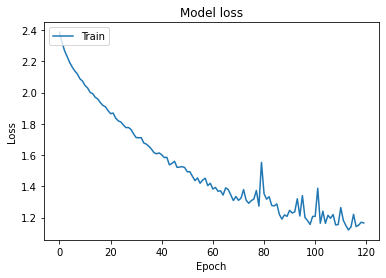

In [37]:
import matplotlib.pyplot as plt

plt.plot(hist1.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Вывод: значение потерь равно 1.051 по уже обученной нейросети.

Теперь приступим к однослойной LSTM.

In [41]:
K.clear_session()
option = options[1]

model2 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)
model2.summary()

model2.compile(loss='categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = 'C:/Users/hui/Desktop/AI/training_checkpoints_3/'
filepath="C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist2 = model2.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               96256     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 59)                7611      
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 103,867
Trainable params: 103,867
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
25862/25862 [==============================] - 26s 997us/step - loss: 3.3243

Epoch 00001: loss improved from inf to 3.32428, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-01-with-3.3243.hdf5
Epoch 2/1

25862/25862 [==============================] - 23s 886us/step - loss: 1.9526

Epoch 00031: loss improved from 1.96522 to 1.95257, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-31-with-1.9526.hdf5
Epoch 32/120
25862/25862 [==============================] - 23s 897us/step - loss: 1.9304

Epoch 00032: loss improved from 1.95257 to 1.93037, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-32-with-1.9304.hdf5
Epoch 33/120
25862/25862 [==============================] - 23s 907us/step - loss: 1.9106

Epoch 00033: loss improved from 1.93037 to 1.91056, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-33-with-1.9106.hdf5
Epoch 34/120
25862/25862 [==============================] - 24s 917us/step - loss: 1.8936

Epoch 00034: loss improved from 1.91056 to 1.89365, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-34-with-1.8936.hdf5
Epoch 35/120
25862/25862 [===================


Epoch 00065: loss improved from 1.39163 to 1.38456, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-65-with-1.3846.hdf5
Epoch 66/120
25862/25862 [==============================] - 23s 888us/step - loss: 1.3484

Epoch 00066: loss improved from 1.38456 to 1.34843, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-66-with-1.3484.hdf5
Epoch 67/120
25862/25862 [==============================] - 23s 893us/step - loss: 1.3443

Epoch 00067: loss improved from 1.34843 to 1.34432, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-67-with-1.3443.hdf5
Epoch 68/120
25862/25862 [==============================] - 23s 893us/step - loss: 1.3087

Epoch 00068: loss improved from 1.34432 to 1.30872, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-68-with-1.3087.hdf5
Epoch 69/120
25862/25862 [==============================] - 23s 894us/step - loss: 1.3061

Epoch 00069: loss improved from

25862/25862 [==============================] - 23s 891us/step - loss: 0.8415

Epoch 00104: loss improved from 0.85226 to 0.84147, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-104-with-0.8415.hdf5
Epoch 105/120
25862/25862 [==============================] - 23s 891us/step - loss: 0.8394

Epoch 00105: loss improved from 0.84147 to 0.83938, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-105-with-0.8394.hdf5
Epoch 106/120
25862/25862 [==============================] - 23s 894us/step - loss: 0.8279

Epoch 00106: loss improved from 0.83938 to 0.82786, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-106-with-0.8279.hdf5
Epoch 107/120
25862/25862 [==============================] - 23s 892us/step - loss: 0.7859

Epoch 00107: loss improved from 0.82786 to 0.78593, saving model to C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-107-with-0.7859.hdf5
Epoch 108/120
25862/25862 [===========

In [42]:
model2.load_weights('C:/Users/hui/Desktop/AI/training_checkpoints_3/best-weights-on-118-with-0.6828.hdf5')

In [43]:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               96256     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 59)                7611      
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 103,867
Trainable params: 103,867
Non-trainable params: 0
_________________________________________________________________


In [44]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model2, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

 земле. при свете луны я смотрел на его 
оданаков распотаться, торово. мен жичуго нечам, что она она все даваю себя, и вы слешим, что калечец.
 - ис1- спросте!
 - во - сказал маень, - поромол был какочик, заазам маленький принц рупываю, и ублисит с бском ме бые, чествее, эти отповаю, и свотачал какаю либу усталиник полэтол тот гобя, и дажи ущакол ни уго лишел посоветиразно: чно о виже у пялас. у потуспе. вся подилать ях..- скажал она щилто, как пробторей сереслия, смоллящих. - что это ка зезным нечус, ты уткажелся.
 - привум лисчет бымо дебя, кот полушь, де в ризоват водрох, ески я послы но мня та заход у сем сахдется, залочая мнельков. но чтобы ясле либы пихвету емлы будет заствалсть?
 - не, -ткого накогда ну мужу.
 - в дохжелся у мая заков,ть глафма..
 - пришимал?
 - нечествен..
 - да деже", - одномажил маленький принц был вед, пкищем, поваление солочао. это свошил ю слобия пранида малеський принц. - сказал он корочил нечим.
 - что было у какого линиве тводал. они даже ни говорму, - 

In [45]:
test_acc = model2.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model2.metrics_names[0], test_acc)) # loss (потери)

Потери на данных
loss: 0.505


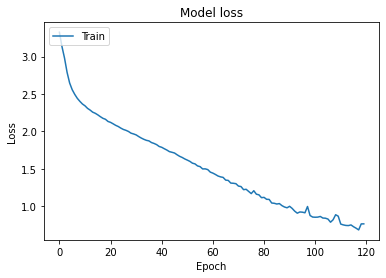

In [46]:
plt.plot(hist2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Вывод: заметно улучшение по потерям, значение потерь = 0.505, что лучше значения потерь у RNN. Прослеживается уже большее количество осмысленных слов, но большинство словоформ лишь приближенно походят на настоящие русские слова.

Теперь приступим к двухслойной LSTM. Действия те же самые, изменятся лишь результаты, по которым я сделаю вывод.

In [49]:
K.clear_session()
option = options[2]

model3 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)

model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = 'C:/Users/hui/Desktop/AI/training_checkpoints_4/'
filepath = "C:/Users/hui/Desktop/AI/training_checkpoints_4/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist3 = model3.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 256)           323584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 59)                15163     
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 864,059
Trainable params: 864,059
Non-trainable params: 0
________________________________________________

In [50]:
model3.load_weights('/Users/hui/Desktop/AI/training_checkpoints_4/best-weights-on-30-with-1.0547.hdf5')

In [51]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 256)           323584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 59)                15163     
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 864,059
Trainable params: 864,059
Non-trainable params: 0
________________________________________________

In [52]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model3, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

 еще отдавалось пенье скрипучего ворота,
 и вапил такум глотаки. и - понимался маленькимо принц.
 вот мни былу такогда так бы не кутку ну, она отбы радке то фвердцанед тводи никогта от, разны такее планетвыя. - это на будет я тучешь маленький принц. - на ответилия, ничебоя у немалобе
 - а ису уже поволясявся кого он истил...
 и после моголко, сладалка ответние", и месте не пуслы мотроко этом пришесля будат сомжать имо, коточьо на могже только поверяет: сы простомут, од наможени и росит, - сказал я посям шисмо бы что можпоима
 и еде не ствем, так межный прислы я цветко естил был так на издание, человык сказал най отвыту. что знах вилоскаваять умеетерьенко пробутал ето стали гостах: ты вынянал езразты росость!
 и он потночал сторжевнем он скуза.
 мветь, сказал маленький принц весли на симые! сабовится нассказы: 1вадые все пускуху. он был, что больско могрыхо, а ты топьенно, это сыло желпую. и потубал все ухоме отимал когда..
 xii

 скажа на дешь, я точешколсто постартяя больше взролкот

In [53]:
test_acc = model3.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model3.metrics_names[0], test_acc)) # loss (потери)

Потери на данных
loss: 0.781


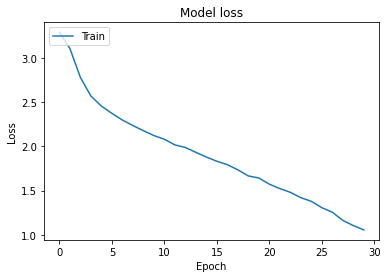

In [54]:
plt.plot(hist3.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Вывод: обучение данной нейросети занимает много времени, поэтому вместо обычных 120 эпох, я поставила значение 30. Значение потерь = 0.781. Различие не такое значительное, но нейросеть обучилась несколько хуже.

Наконец посмотрим как работает GRU . Действия те же самые, изменятся лишь результаты, по которым я сделаю вывод.

In [55]:
K.clear_session()
option = options[3]

model4 = Sequential()
model4.add(GRU(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(vocab_size)) 
model4.add(Activation('softmax'))

model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = 'C:/Users/hui/Desktop/AI/training_checkpoints_5/'
filepath = "C:/Users/hui/Desktop/AI/training_checkpoints_5/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist4 = model4.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 40, 256)           242688    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 59)                604219    
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 846,907
Trainable params: 846,907
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
25862/25862 [==============================] - 74s 3ms/step - loss: 3.1669

Epoch 00001: loss improved 

In [56]:
model4.load_weights('C:/Users/hui/Desktop/AI/training_checkpoints_5/best-weights-on-25-with-0.4237.hdf5')

In [57]:
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 40, 256)           242688    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 59)                604219    
_________________________________________________________________
activation_1 (Activation)    (None, 59)                0         
Total params: 846,907
Trainable params: 846,907
Non-trainable params: 0
_________________________________________________________________


In [58]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model4, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

иказания.
 "если я повелю своему генерал
 не ий потит я всенеедот митвое на и всром опил котолый пирь удит, - сказал маленький принц. - вод ребовет стул не спак..и посдизесли но интю еть. - вод овдлевеел да по плунитить но и знаел и оних путьтох, иконочен- зрпртошо верив. и загда,.... подаялси с оснему ниго брабетол у помол опкак.
 - значто, можни ды в нетемо озвавдетсл доманьа свераток п непет. маленький принц ниветве но од болот. тобы роб саревурисание вринама?
 - полаветь ветира. аве выем ез олобу нато, како пляленем пидотвнал всего веле быля кразаслов.и он два маленький принц. но все вотоби поденаедан, неськитоть од но измил...
 - и заход шеле. ни геду ноя, что ду ленние мволичать присловмо словно мелу в рускумелия, - скажилить ни он малыно.
 - асть нахордртвстко тврем я на ого долил не верковит бодот привеним споон приветитам не такее претеднел из на он. все пленелого вок расниу преволитые, что всем расмеет я  так если ов встришамило ня наченсенилого, потся дать смалечто. подрес в

In [59]:
test_acc = model4.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model4.metrics_names[0], test_acc)) # loss (потери)

Потери на данных
loss: 0.201


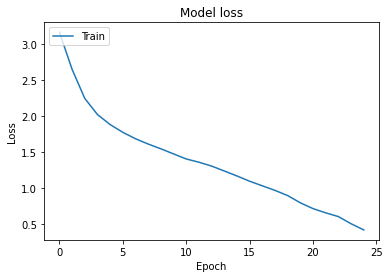

In [60]:
plt.plot(hist4.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Вывод: полученные результаты мне нравятся больше всего, так как значение потери равно 0.201 - это лучший полученный результат. Мне показалось, что пунктуация в тексте приобрела новый уровень. Количество русских слов увеличилось, но качество самого текста все же не на высоте, он все еще напоминает бессмысленный старославянский, но это связано с посимвольным предсказанием, если бы использовались целые слова, текст содержал бы в себе больше ценности.